In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
import scipy
import os

import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import r2_score

plt.rcParams["font.family"] = "serif"
dpi = 200
matplotlib.rcParams['figure.dpi']= dpi
matplotlib.rcParams.update({'font.size':15})

def parse_predictions(filename):
    df = pd.read_csv(filename, delimiter=',', header=0, index_col=False)
    real_str = df['real'].values
    pred_str = df['pred'].values
    real = [np.fromstring(item.strip('[]'), sep=' ') for item in real_str]
    pred = [np.fromstring(item.strip('[]'), sep=' ') for item in pred_str]
    return real, pred

def calculate_chi_square(y, y_hat, yerr):
    chi_square = np.mean(((y - y_hat) / yerr) ** 2)
    return chi_square

def calculate_r2(y, y_hat):
    return r2_score(y, y_hat)

def calculate_relative_error(y, y_hat):
    relative_error = np.mean(np.abs((y - y_hat) / y) * 100)
    return relative_error

def calculate_mse(y, y_hat):
    mse = np.mean((y - y_hat) ** 2)
    return mse

def bootstrap_metric(y_true, y_pred, metric_fn, n_bootstrap=1000, seed=1234, **kwargs):
    rng = np.random.default_rng(seed)
    n_samples = len(y_true)
    metric_values = []

    for _ in range(n_bootstrap):
        indices = rng.choice(n_samples, size=n_samples, replace=True)
        metric = metric_fn(y_true[indices], y_pred[indices], **{k: v[indices] if isinstance(v, np.ndarray) else v for k, v in kwargs.items()})
        metric_values.append(metric)

    metric_values = np.array(metric_values)
    mean_metric = np.mean(metric_values)
    ci_lower = np.percentile(metric_values, 2.5)
    ci_upper = np.percentile(metric_values, 97.5)

    return mean_metric, (ci_lower, ci_upper), metric_values
    
def plot_loss(directory, printing = False):
    fig, axes = plt.subplots(figsize=(3,3))
    train = np.loadtxt(directory + "train_losses.csv", skiprows=1)
    validation = np.loadtxt(directory + "val_losses.csv", skiprows=1)
    plt.plot(train, label="Training Loss")
    plt.plot(validation, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.show()

    if printing:
        print(f"Minimum Training Loss:   {np.min(train):.3f}, epoch: {np.argmin(train)}")
        print(f"Minimum Validation Loss: {np.min(validation):.3f}, epoch: {np.argmin(validation)}")


In [2]:
def plot_params(directory, target_labels=[r'$\Omega_{\rm m}$', r'$\sigma_8$'], title=None, printing=False, loss=True, zero=False):
    stats = []
    
    try:
        filename = directory + '/pred.txt'
        y_values, y_hat_values = parse_predictions(filename)
        if not zero:
            loss_filename = directory + '/val_losses.csv'
            train = np.loadtxt(directory + "train_losses.csv", skiprows=1)
            validation = np.loadtxt(directory + "val_losses.csv", skiprows=1)
    except Exception as e:
        return
    
    y_values = np.array(y_values)
    y_hat_values = np.array(y_hat_values)

    num_params = len(target_labels)
    
    colors = ["blue", "green"] 
    if loss:
        fig, axes = plt.subplots(1, 1+num_params, figsize=(15, 4))  # 1x3 layout for Om, S8, and Loss
    else:
        fig, axes = plt.subplots(1, num_params, figsize=(9, 4))

    if title is not None:
        fig.suptitle(title)

    for i in range(num_params):
        ax = axes[i]
        y_pred = y_hat = y_hat_values[:, i]
        y_true = y_values[:, i]
        y_error = np.abs(y_hat_values[:,i+len(target_labels)])
        
        ax.errorbar(
            x=y_true, y=y_hat, yerr=y_error, fmt='o', color=colors[i], ecolor=colors[i], markersize=3, elinewidth=0.3,
            label=target_labels[i]
        )
        
        # Calculate metrics
        # R²
        mean_r2, (_, _), r2_values = bootstrap_metric(y_true, y_pred, calculate_r2)
        std_r2 = np.std(r2_values)
    
        # Relative error
        mean_rel, (_, _), rel_values = bootstrap_metric(y_true, y_pred, calculate_relative_error)
        std_rel = np.std(rel_values)
    
        # MSE
        mean_mse, (_, _), mse_values = bootstrap_metric(y_true, y_pred, calculate_mse)
        std_mse = np.std(mse_values)
    
        # Chi²
        mean_chi2, (_, _), chi2_values = bootstrap_metric(y_true, y_pred, calculate_chi_square, yerr=y_error)
        std_chi2 = np.std(chi2_values)
        
        stats.append([mean_r2, std_r2, mean_rel, std_rel, mean_mse, std_mse, mean_chi2, std_chi2])
        
        ax.plot([-1, 10], [-1, 10], 'r--', label='Ideal Fit')
        
        ax.set_xlim(min(y_values[:, i]), max(y_values[:, i]))
        ax.set_ylim(min(y_values[:, i]), max(y_values[:, i]))
        
        ax.set_xlabel(r'Ground Truth ($y$)')
        if i==0:
            ax.set_ylabel(r'Predicted values ($\hat{y}$)')
            
        ax.set_title(target_labels[i])
        #ax.legend(loc='lower right')
        ax.grid(True)
        
        exponent = int(np.floor(np.log10(mean_mse)))
        base_mean = mean_mse / 10**exponent
        base_std = std_mse / 10**exponent
        
        metrics_text = (
            rf"$R^2 = {mean_r2:.2f} \pm {std_r2:.2f}$" + "\n" +
            rf"$\epsilon = {mean_rel:.2f} \pm {std_rel:.2f}\%$" + "\n" +
            rf"$\mathrm{{MSE}} = ({base_mean:.2f} \pm {base_std:.2f}) \times 10^{{{exponent}}}$" + "\n" +
            rf"$\chi^2 = {mean_chi2:.2f} \pm {std_chi2:.2f}$"
        )
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    if loss:
        ax = axes[num_params]
        train = np.loadtxt(directory + "train_losses.csv", skiprows=1)
        validation = np.loadtxt(directory + "val_losses.csv", skiprows=1)
        ax.plot(train, label="Training Loss")
        ax.plot(validation, label="Validation Loss")
        ax.legend()
        ax.set_xlabel("Epochs")
        ax.set_title("Training & Validation Loss")
        ax.grid(True)

        if printing:
            print(f"Minimum Training Loss:   {np.min(train):.3f}, epoch: {np.argmin(train)}")
            print(f"Minimum Validation Loss: {np.min(validation):.3f}, epoch: {np.argmin(validation)}")

    plt.tight_layout()
    if loss == True:
        plt.show()
    return stats, plt

In [3]:
def extract_layer_type(directory, i):
    log_file = os.path.join(directory, f"trial_{i}", "training.log")
    
    try:
        with open(log_file, 'r') as f:
            for line in f:
                if "layerType:" in line:
                    layer_type = line.strip().split("layerType:")[-1].strip()
                    return layer_type
        print(f"Trial {i} - layerType not found.")
    except FileNotFoundError:
        print(f"Trial {i} - Log file not found.")
        
def summary(start, end, directory, loss=False, target_labels=[r'$\Omega_{\rm m}$', r'$\sigma_8$']):
    all_stats = []
    score_dict = {}

    vals = []
    for i in range(start, end):
        fn = directory + f"trial_{i}/val_losses.csv"
        try:
            df = pd.read_csv(fn)
            val = df.to_numpy().min()
        except Exception as e:
            val = np.inf
    
        vals.append(float(val))
    
    vals = np.array(vals)
    best_idx =  np.argmin(vals)
    
    bestLayerType =  extract_layer_type(directory, best_idx)
    print("Layer Type: ", bestLayerType)
    log = directory + f"trial_{i}/training.log"
    failed_list = list(np.where(np.isinf(vals))[0])
    print(f"We have {end-start-len(failed_list)}/{end-start} valid samples.")
    
    directory = directory + f"/trial_{best_idx}/"
    stats, _ = plot_params(directory, loss=loss, target_labels=target_labels)
    try:
        get_model_size(directory + "best_checkpoint.pth")
    except:
        get_model_size(directory + "best_model.pt")

    prefix_integrated = "integrated_" if "integrated" in directory else ""
    if len(target_labels) == 2:
        return stats[0], stats[1], prefix_integrated+bestLayerType
    else:
        return stats, prefix_integrated+bestLayerType

In [4]:
def get_model_size(path):
    state_dict = torch.load(path, map_location='cpu')
    if 'model' in state_dict:
        state_dict = state_dict['model']
    elif 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    
    total_params = 0
    for name, param in state_dict.items():
        total_params += param.numel()
    
    print(f"\nTotal number of parameters: {total_params/1e3}K")

Layer Type:  TNN
We have 300/303 valid samples.


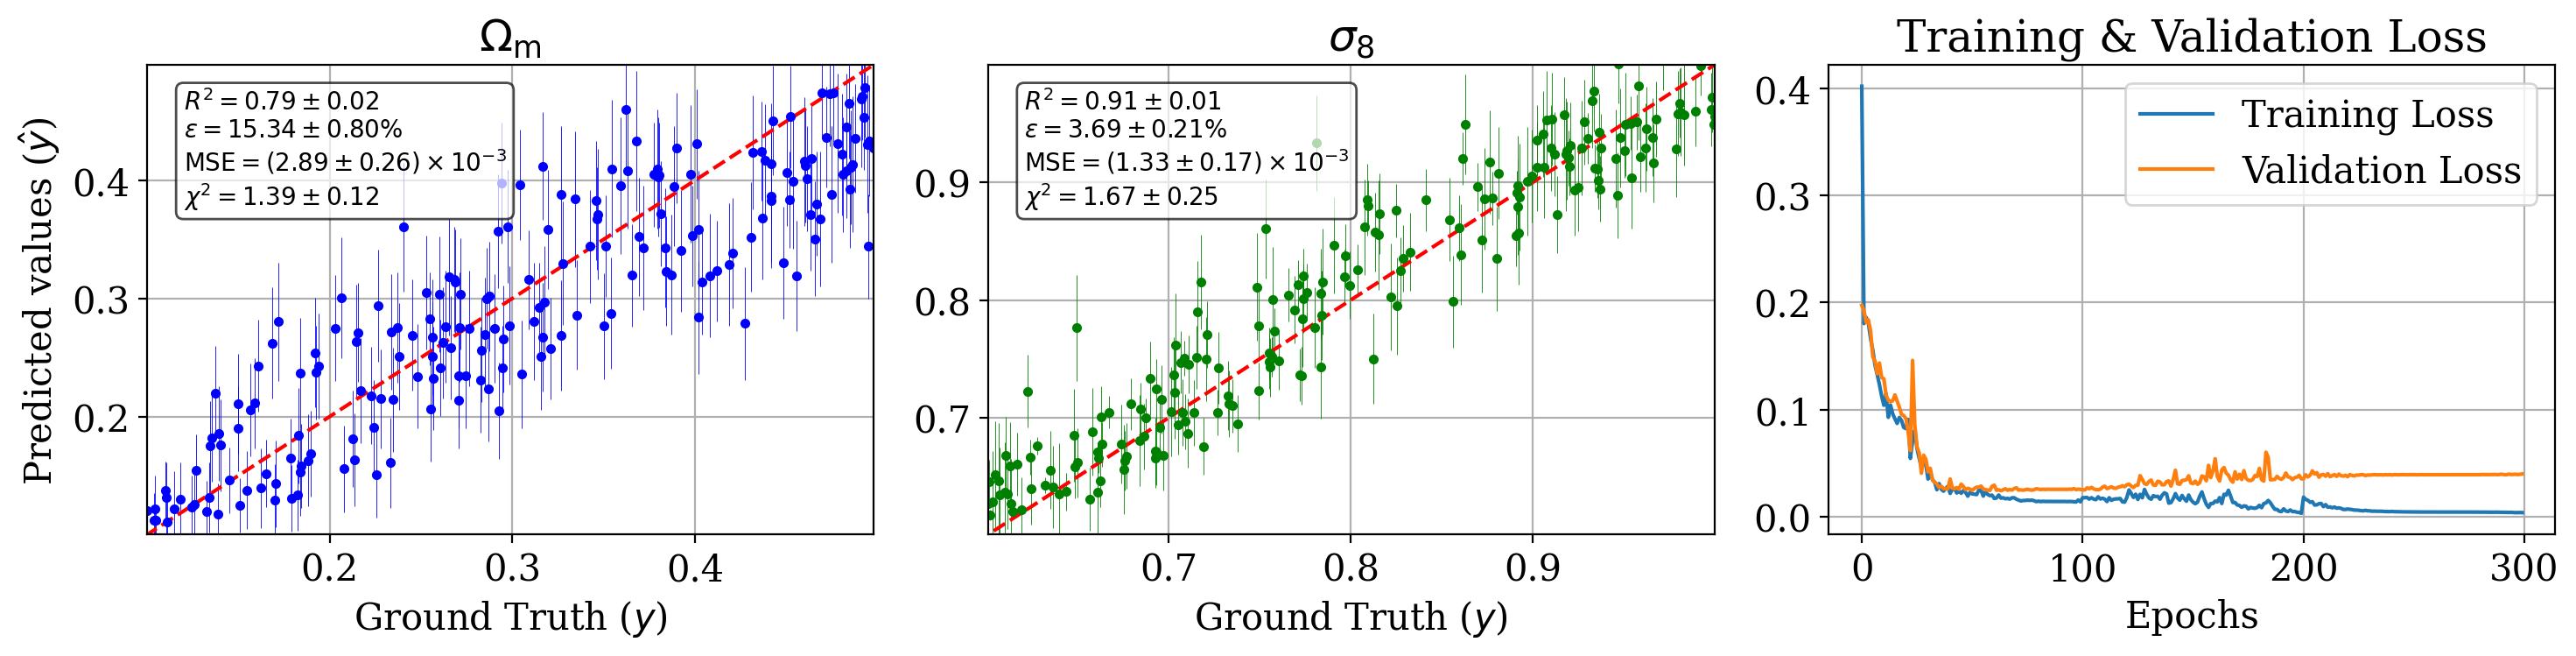


Total number of parameters: 5052.868K
Layer Type:  GNN
We have 100/100 valid samples.


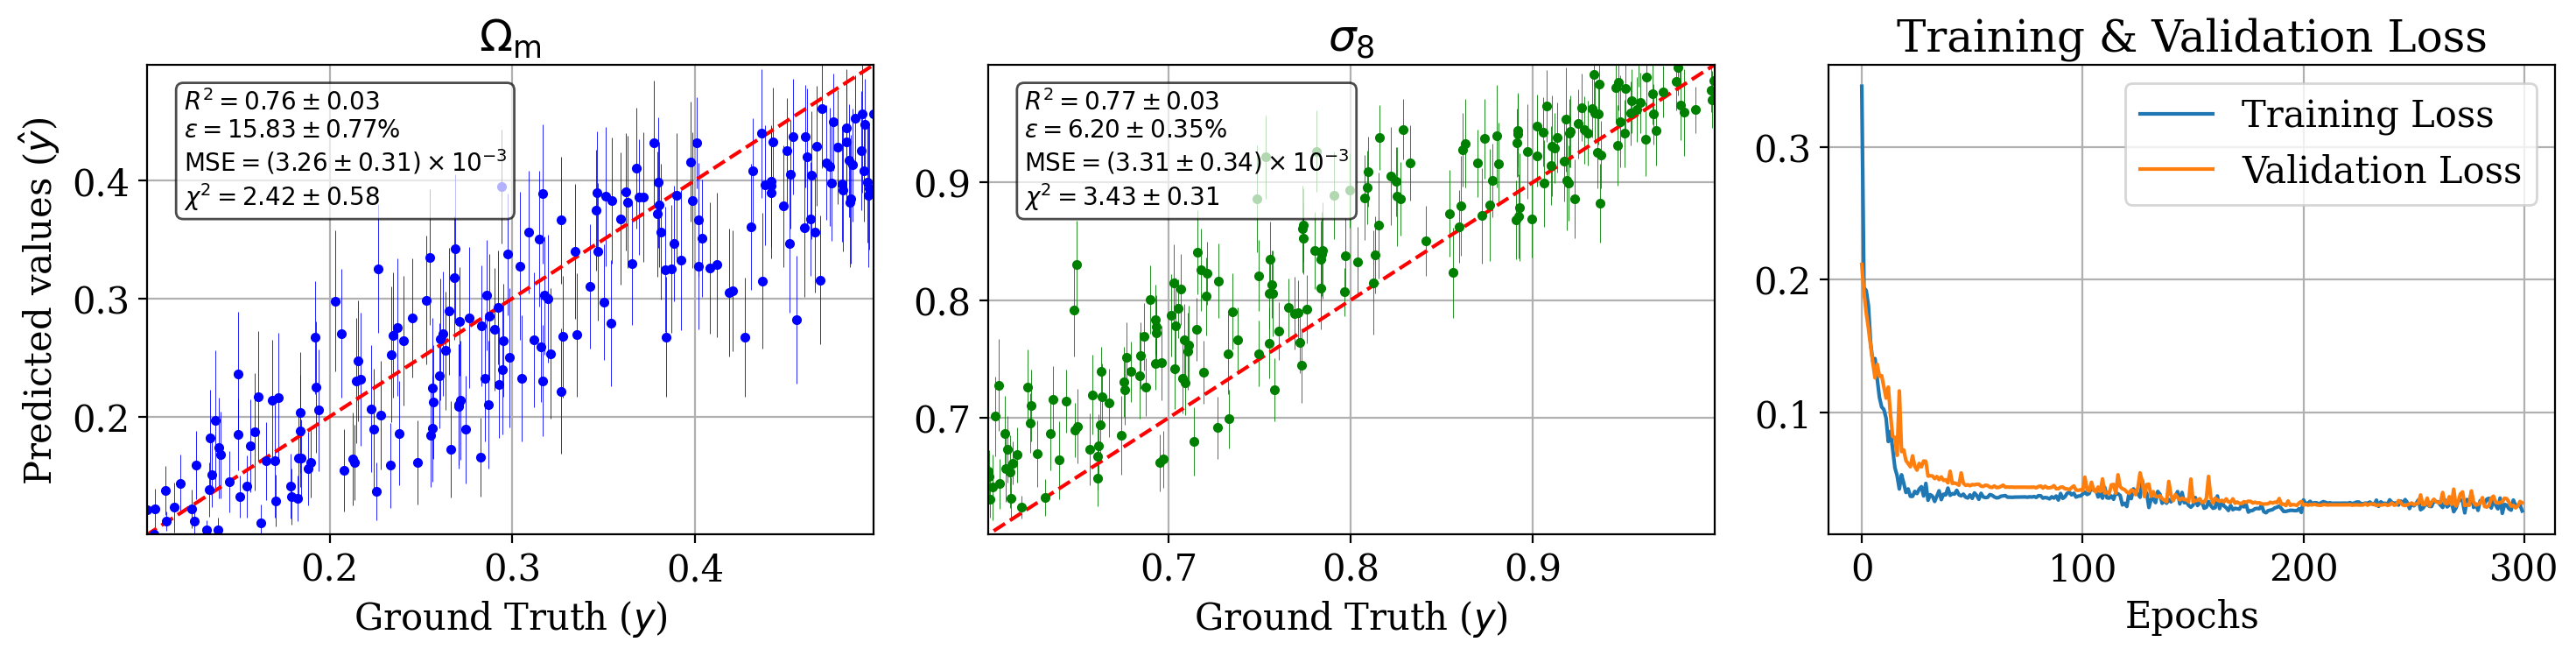


Total number of parameters: 151.492K
Layer Type:  TetraTNN
We have 100/100 valid samples.


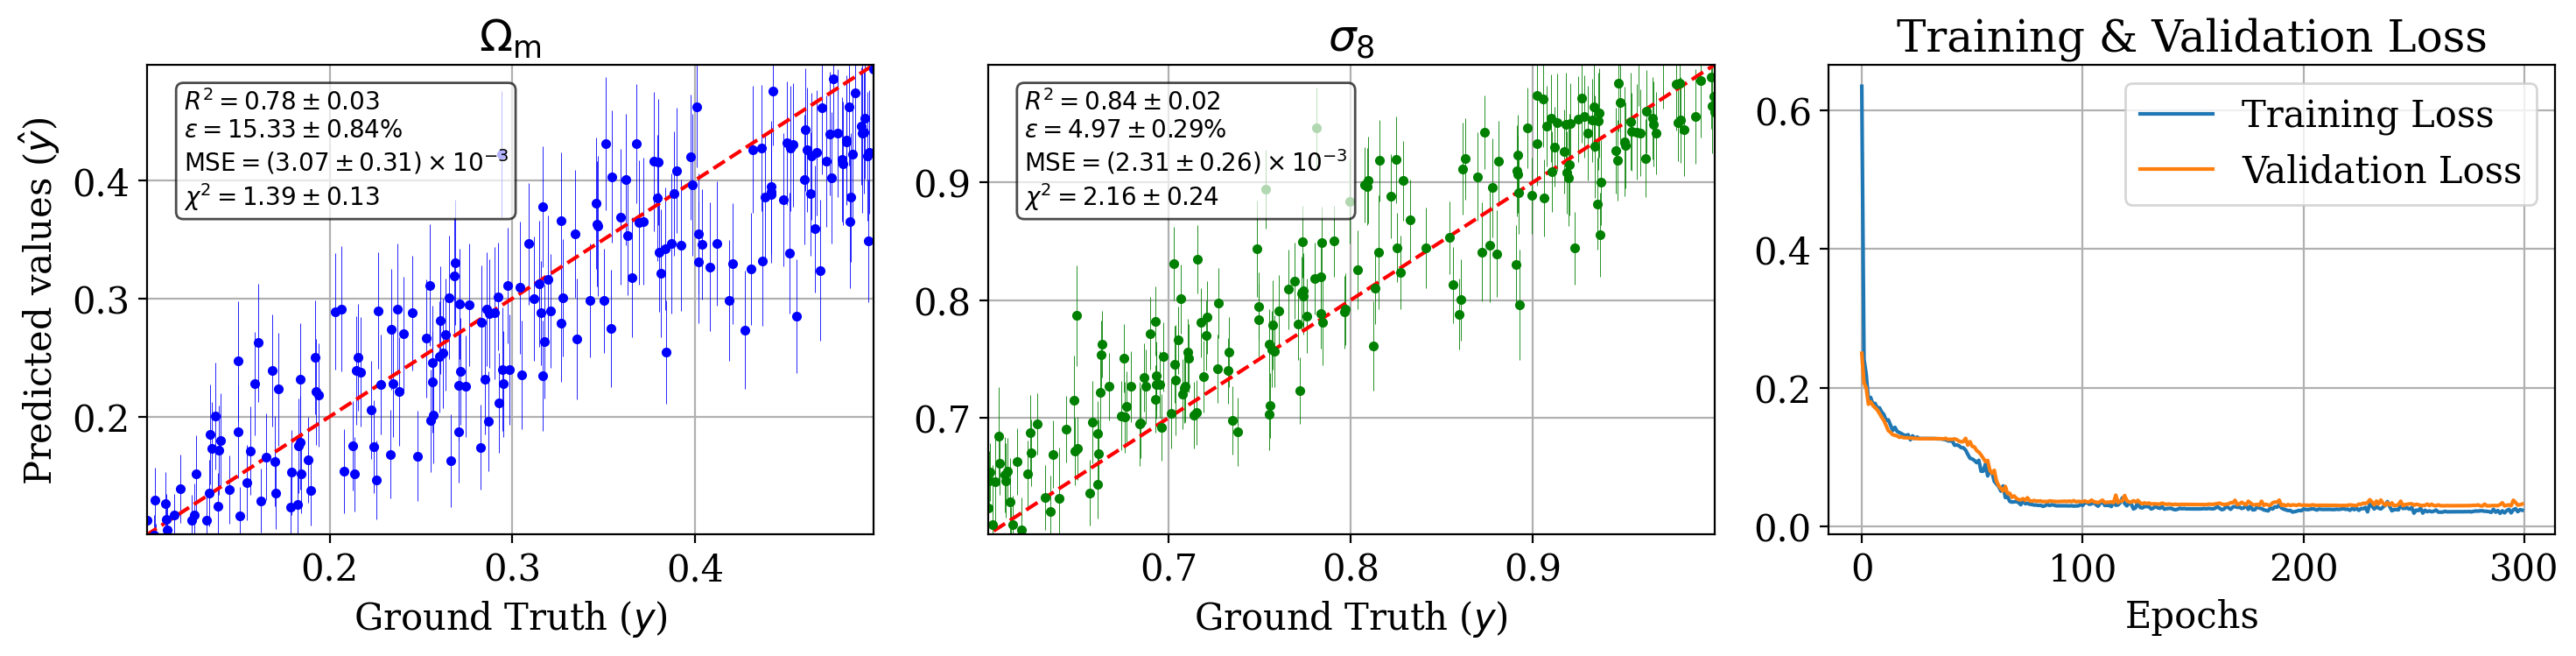


Total number of parameters: 4158.66K
Layer Type:  ClusterTNN
We have 100/100 valid samples.


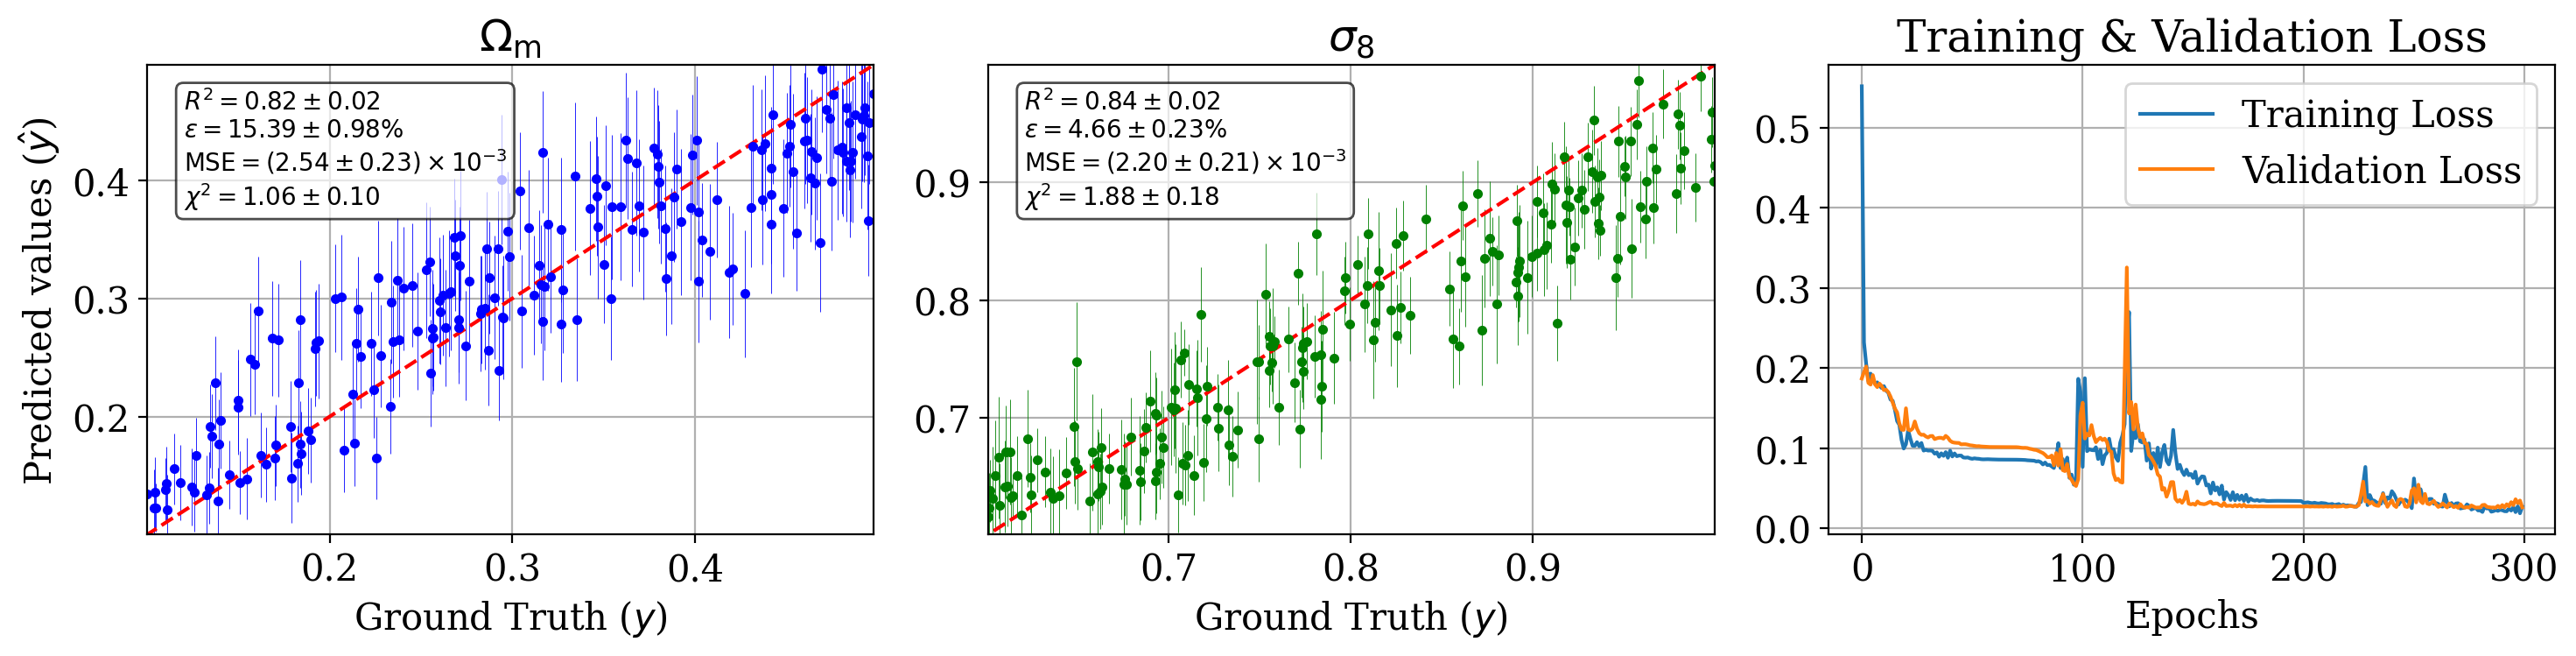


Total number of parameters: 1836.484K
Layer Type:  TNN
We have 100/100 valid samples.


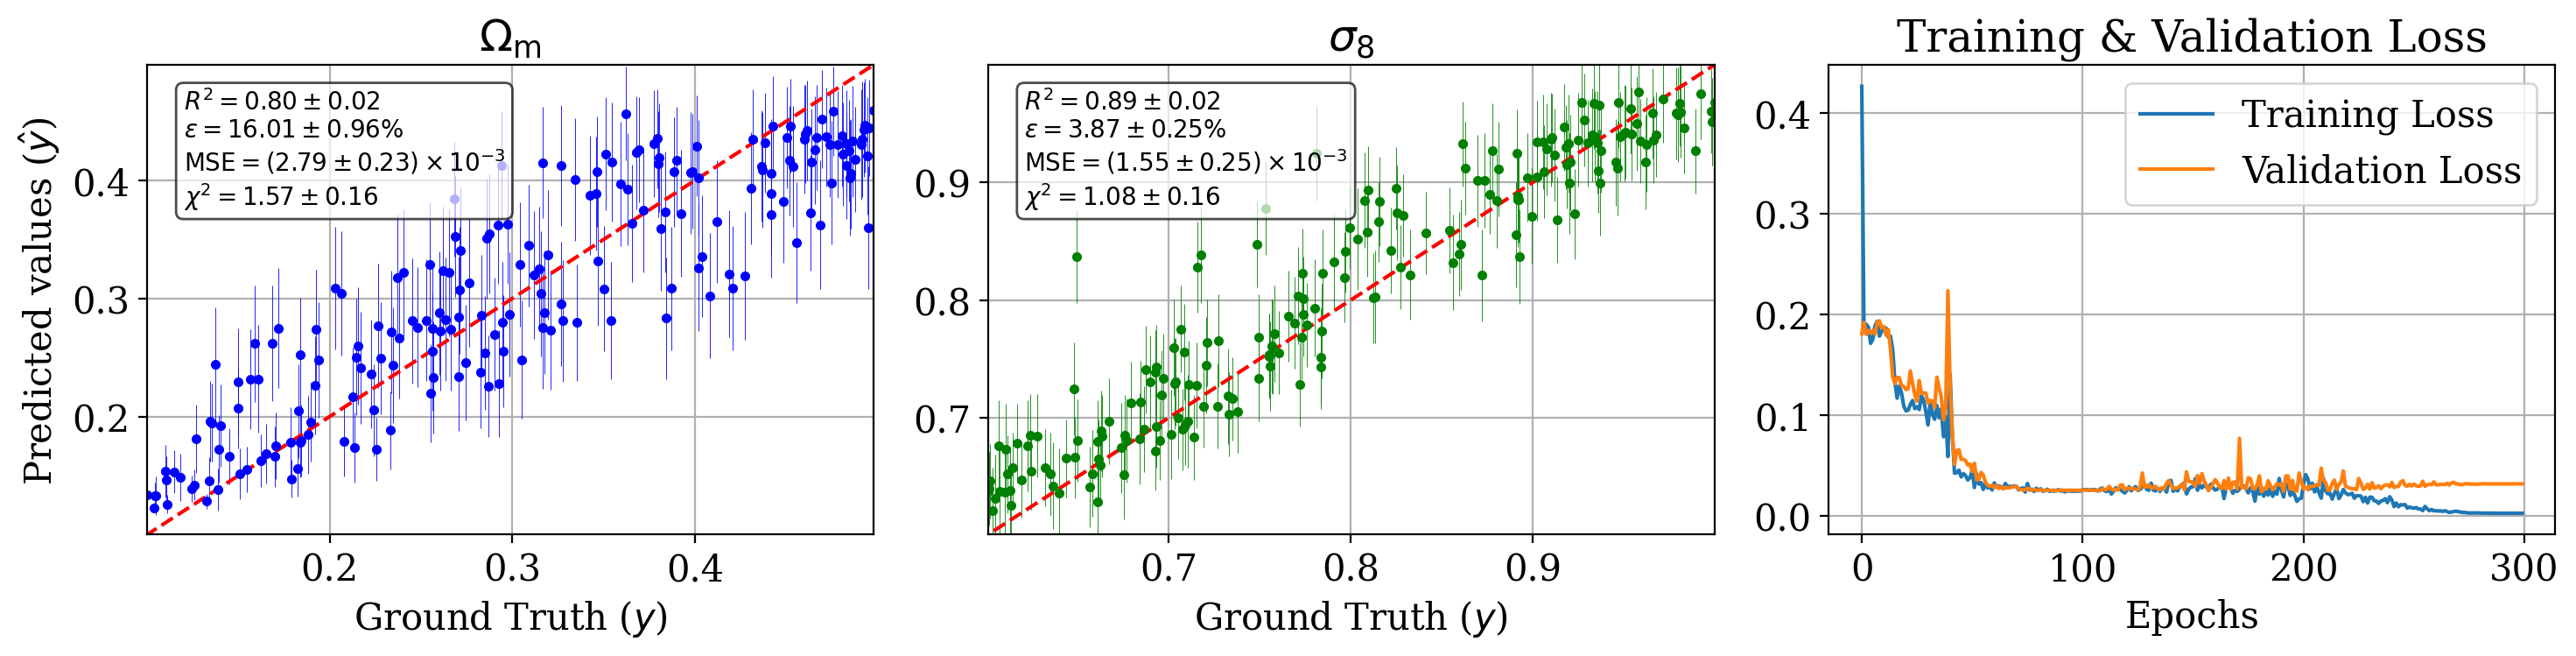


Total number of parameters: 9162.436K


In [5]:
columns = [
    'model',
    'mean_r2', 'std_r2',
    'mean_rel', 'std_rel',
    'mean_mse', 'std_mse',
    'mean_chi2', 'std_chi2'
]

Om_stat_list = []
s8_stat_list = []
model_list = []

BENCH_PATH = " " #your_path
Om_stat, s8_stat, best_model = summary(0, 303, BENCH_PATH, True)
Om_stat_list.append(Om_stat)
s8_stat_list.append(s8_stat)
model_list.append(best_model)

for model in ['GNN', 'TetraTNN', 'ClusterTNN', 'TNN']:
    print("="*50)
    MODEL_PATH = f"put_in_your_path/isolated_Quijote_{model}/"
    Om_stat, s8_stat, best_model = summary(0, 100, MODEL_PATH, True)
    Om_stat_list.append(Om_stat)
    s8_stat_list.append(s8_stat)
    model_list.append(best_model)

df_quijote_om = pd.DataFrame([
    [model] + list(stat) for model, stat in zip(model_list, Om_stat_list)], columns=columns)

df_quijote_s8 = pd.DataFrame([
    [model] + list(stat) for model, stat in zip(model_list, s8_stat_list)], columns=columns)

Layer Type:  GNN
We have 300/300 valid samples.


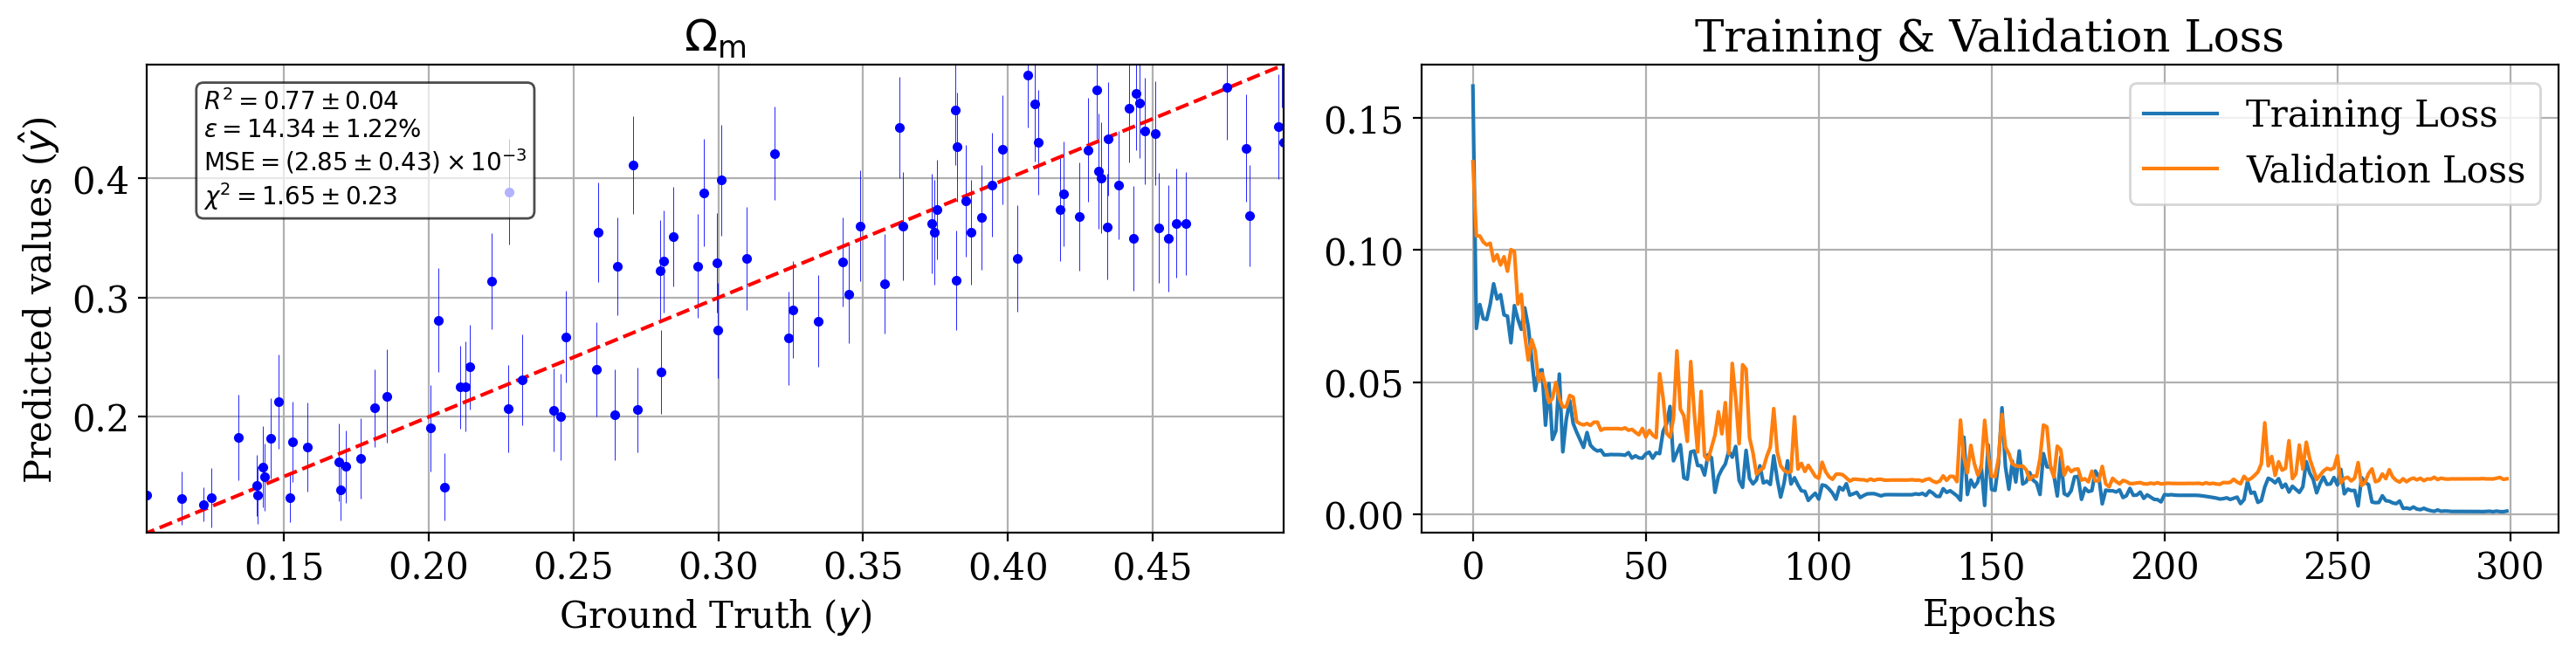


Total number of parameters: 13210.946K
Layer Type:  GNN
We have 100/100 valid samples.


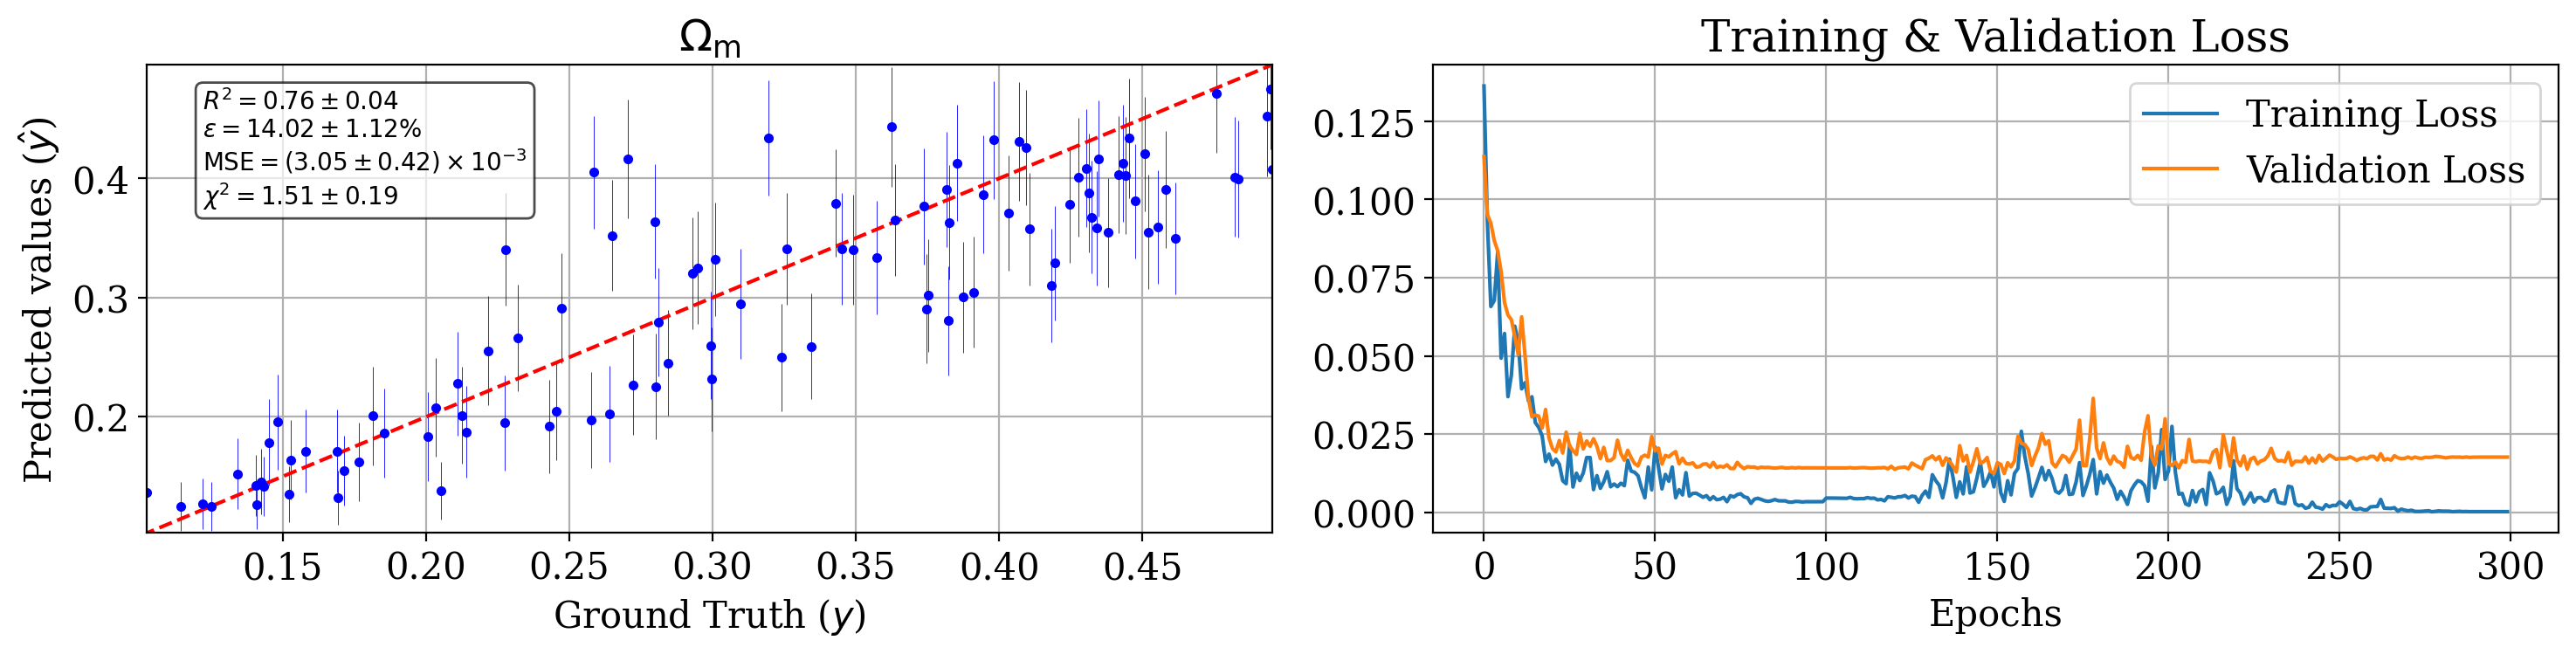


Total number of parameters: 4155.714K
Layer Type:  TetraTNN
We have 100/100 valid samples.


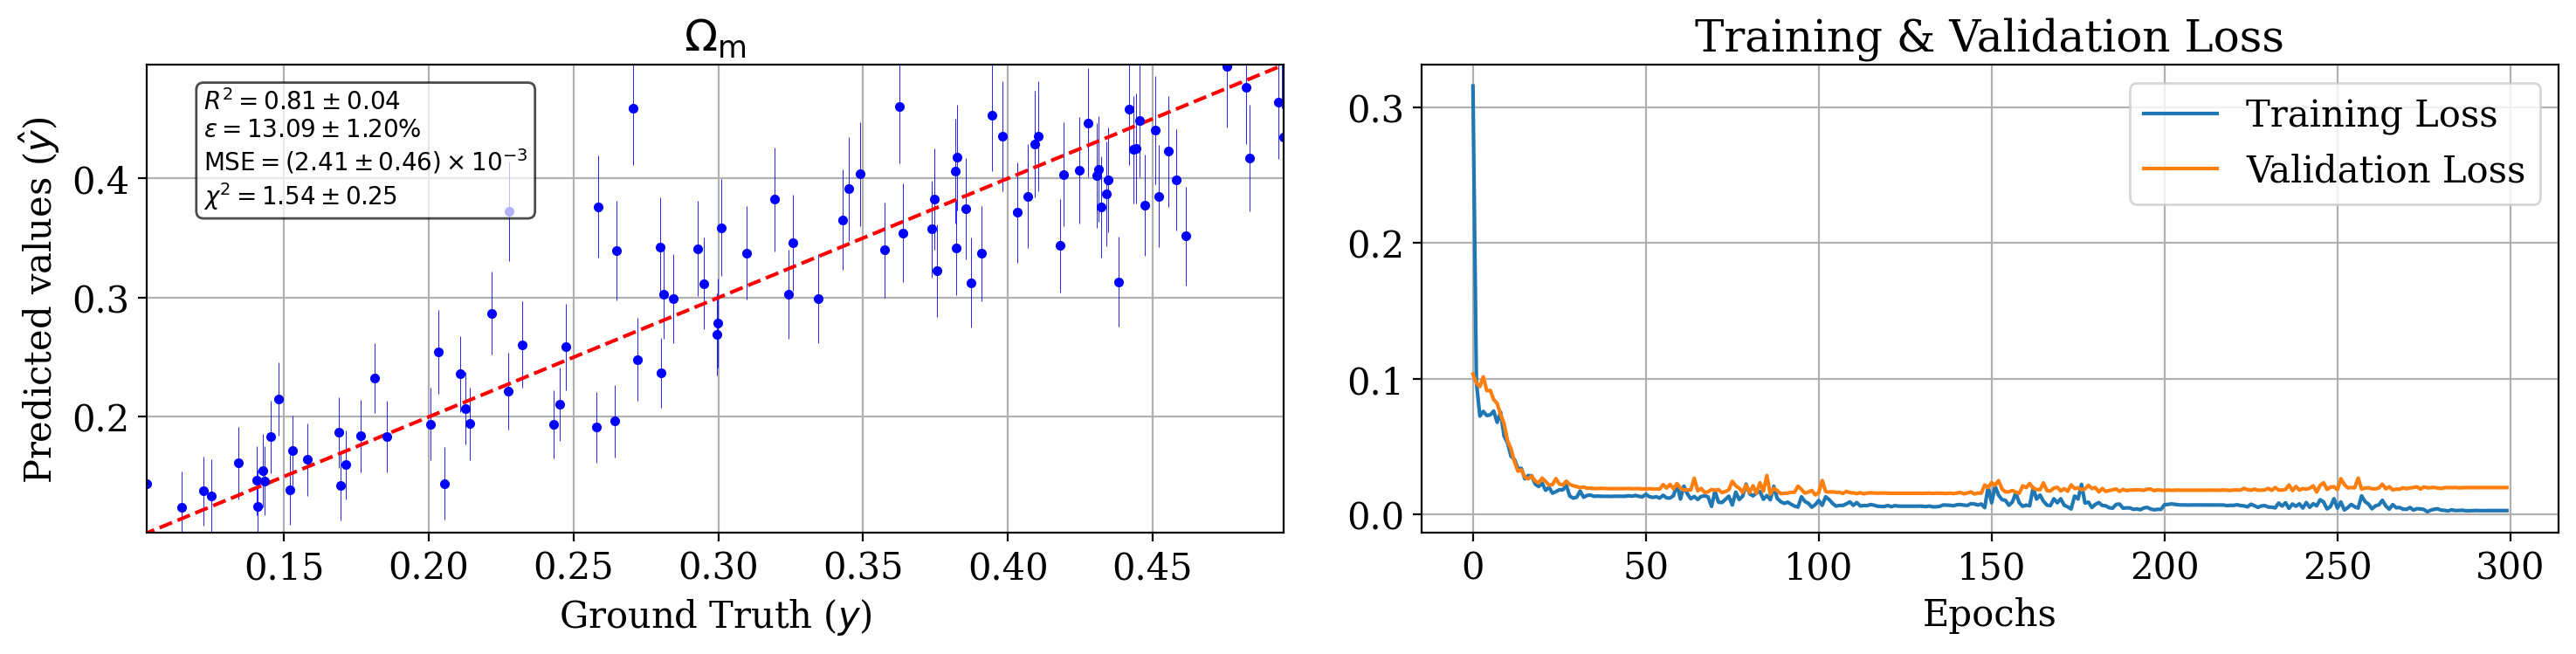


Total number of parameters: 4158.53K
Layer Type:  ClusterTNN
We have 100/100 valid samples.


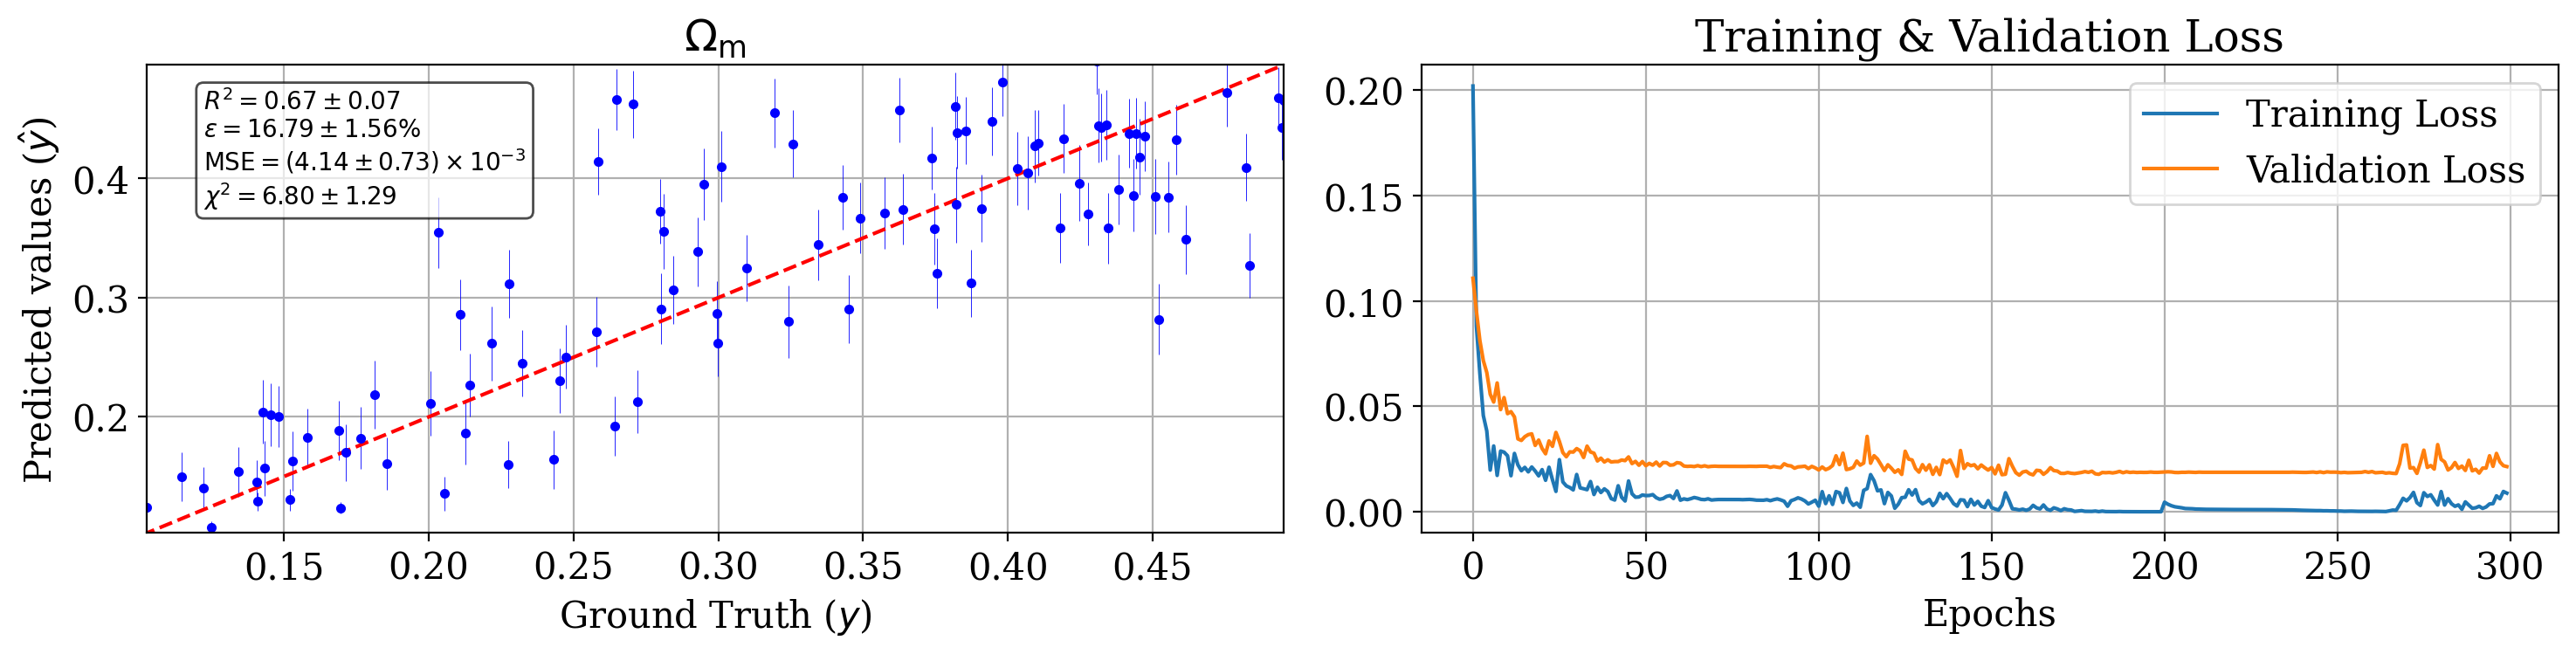


Total number of parameters: 714.306K
Layer Type:  TNN
We have 100/101 valid samples.


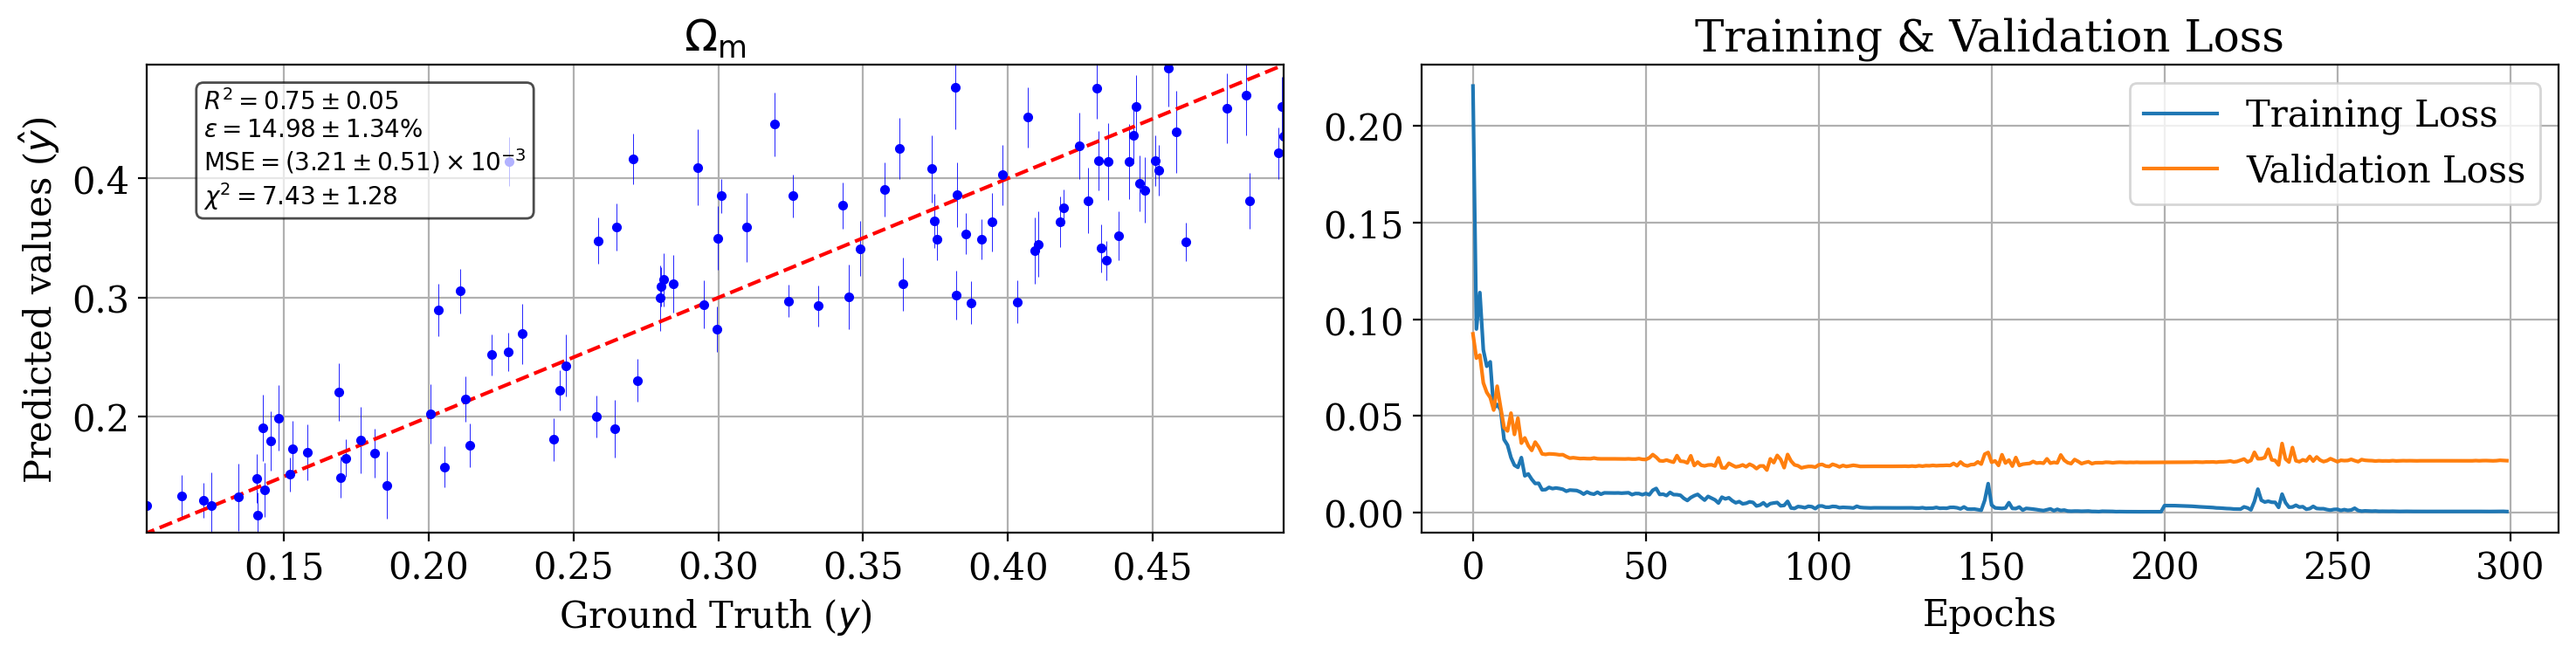


Total number of parameters: 956.738K


In [6]:
BENCH_PATH = " " #your_path
stat_list = []
model_list = []

stat, best_model = summary(0, 300, BENCH_PATH, True, target_labels=[r'$\Omega_{\rm m}$'])
stat_list.append(*stat)
model_list.append(best_model)

for model in ['GNN', 'TetraTNN', 'ClusterTNN', 'TNN']:
    print("="*50)
    MODEL_PATH = f"put_in_your_path/isolated_CAMELS_{model}/"
    stat, best_model = summary(100, end, MODEL_PATH, True, target_labels=[r'$\Omega_{\rm m}$'])
    stat_list.append(*stat)
    model_list.append(best_model)
        
df_camels = pd.DataFrame([
    [model] + list(stat) for model, stat in zip(model_list, stat_list)], columns=columns)